In [72]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from matplotlib import animation
from tqdm import tqdm
from itertools import cycle
from scipy import special

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.grid'] = True

In [73]:
def c(x, t, D=1):
    tmp = 0
    for i in range(0, 1000):
        tmp += special.erfc((1 - x + 2 * i) / (2 * np.sqrt(D*t))) \
               - special.erfc((1 + x + 2 * i) / (2 * np.sqrt(D*t)))
    return tmp

In [74]:
# MACROS
N = 100

# mask
mask = np.ones((N, N))
mask[N-1][N//2] = 0

# analytical sor
x = np.linspace(0, 1, N)
a_sor_1d = c(x, 10000)
a_sor_2d = np.flipud(np.tile(a_sor_1d,(N,1)).T)

In [75]:
mycmap = plt.get_cmap('hot')
mycmap.set_under('w')

def animate(images, name, interval=50, cmap=mycmap):
    fig = plt.figure()

    ims = []
    for img in images:
        im = plt.imshow(img, interpolation="bicubic", animated=True, cmap=cmap, vmin=0.000001)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True,
                                    repeat_delay=1000)

    ani.save(name)

## 2.1

In [76]:
# return right, top, left, bottom
@njit
def get_neighbors(i, j):
    return [(i, j+1), (i-1, j), (i, j-1), (i+1, j)]

In [77]:
@njit
def SOR(u2, mask2, epsilon=10e-5, omega=1.9):
    
    u = np.copy(u2)
    mask = np.copy(mask2)
    
    if mask.shape[0] != u.shape[0]:
         raise Exception("U and mask have different dimensions")  
            
    N = mask.shape[0]

    new = u
    old = np.full((N, N), np.inf)
    
    iterations = 0

    while(np.amax(np.abs(new - old)) >= epsilon):
        old = np.copy(u) 
        for i in range(1, N-1):
            for j in range(N):
                ln = j - 1
                rn = j + 1

                # periodic boundaries
                if j == 0:
                    ln = N-1
                elif j == N-1:
                    rn = 0
                    
                if mask[i][j] == 0:
                    u[i][j] = 0
                else:                        
                    u0 = old
                    u[i][j] = (omega/4) * (u[i+1][j] + u[i-1][j] + u[i][rn] + u[i][ln]) + (1 - omega) * (u0[i][j])
        new = u
        iterations += 1
        
    return u, iterations

In [78]:
@njit
def DLA(sor_u, mask_u, eta=1):
    if mask_u.shape[0] != sor_u.shape[0]:
        raise Exception("U and mask have different dimensions")  
        
    N = mask_u.shape[0]
    
    mask = np.copy(mask_u)
    sor = np.copy(sor_u)
    
    candidates = []    
    sum_growth = 0   
    
    # get all growth candidates    
    for i, j in np.ndindex(N, N):
        if mask[i][j] == 0:
            neighbors = get_neighbors(i, j)

            for neighbor in neighbors:
                if (neighbor[0] >= 0 and neighbor[0] < N) and (neighbor[1] >= 0 and neighbor[1] < N):
                    sum_growth += np.power(sor[neighbor], eta)
                    candidates.append(neighbor)
                        
    # determine for each candidate wheter it is succesful
    for candidate in candidates:
        p_growth = np.power(sor[candidate], eta) / sum_growth
        rnd = np.random.uniform(0, 1)
        if rnd < p_growth:
            sor[candidate] = 0
            mask[candidate] = 0
                        
    return sor, mask            

In [79]:
def run_dla(u, mask, eta, max_cluster_size):
    dlas = [u]
    cluster_size = np.count_nonzero(mask == 0)
    
    while cluster_size < max_cluster_size:
        sor, mask = DLA(u, mask, eta=eta)   
        u, _ = SOR(sor, mask)
        cluster_size = np.count_nonzero(mask == 0) # can exceed max_cluster_size if 2 or more are being added in same timestep
        dlas.append(u)
        
    return dlas, mask

*Experiments*

In [80]:
# RUNS FOREVER

cluster_sizes = [0, 100, 200, 300, 400]
clusters = []

omegas = np.linspace(1.71, 1.99, 50)

# build 10 different clusters per size
for size in cluster_sizes:
    tmp_clusters = []
    for _ in range(10):        
        _, c = run_dla(a_sor_2d, mask, 2, size)
        tmp_clusters.append(c)
    clusters.append(tmp_clusters)
    
iterations = []

for i in range(len(clusters)):
    r_iterations = []
    for j in range(len(clusters[0])):
        c_iterations = []
        for om in omegas:
            source = np.zeros((N, N))
            source[0] = np.ones((1, N))
            
            _, it = SOR(source, clusters[i][j], omega=om)
            c_iterations.append(it)
        r_iterations.append(c_iterations)
    iterations.append(r_iterations)

In [70]:
colors = cycle(["r", "g", "y", "c", "m", "y"])

for i in range(len(cluster_sizes)):
    line_color = next(colors)
    
    avg_iterations = np.mean(iterations[i], axis=0)
    
    if i == 0:
        plt.plot(omegas[np.where(avg_iterations == min(avg_iterations))], min(avg_iterations), "*", alpha=0.5, c=line_color, markersize=10)
        plt.plot(omegas, avg_iterations, "--", alpha=0.5, c=line_color, label="cluster size: " + str(cluster_sizes[i]))
    else:
        plt.plot(omegas[np.where(avg_iterations == min(avg_iterations))], min(avg_iterations), "*", c=line_color, markersize=10)
        plt.plot(omegas, avg_iterations, c=line_color, label="cluster size: " + str(cluster_sizes[i]))
    
plt.title("Avg iterations (N = 100, repetitions = 10)")
plt.xlabel(r" $\omega$")
plt.ylabel("iterations k")

plt.ylim(100, 900)
plt.xlim(1.71, 1.99)

plt.legend()

NameError: name 'cluster_sizes' is not defined

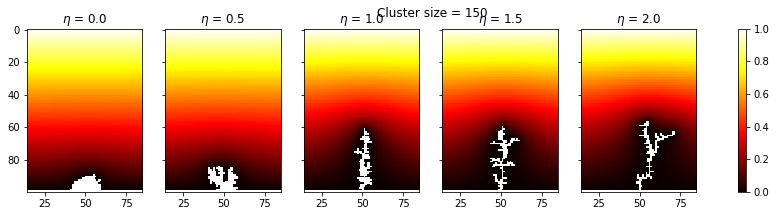

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharex='col', sharey='row')

for i, e in enumerate([0.0, 0.5, 1.0, 1.5, 2.0]):
    us, _ = run_dla(a_sor_2d, mask, e, 150)
    u = us[-1]
    
    ax = axes.flat[i]
    im = ax.imshow(u, cmap=mycmap, vmin=0.000000000000001, vmax=1)
    ax.set_title(r"$\eta$ = " + str(e))
    ax.grid('off')
    
fig.suptitle("Cluster size = 150")
fig.colorbar(im, ax=axes.ravel().tolist())

## 2.2

In [10]:
@njit
def random_walker(pos, N, mask):
    i, j = pos
    neighbors = get_neighbors(i, j)
    
    for i, neighbor in enumerate(neighbors):
        if neighbor[0] == -1 or neighbor[0] == N:
            neighbors[i] = (-1, -1) 
        elif mask[neighbor] == 0:
            neighbors.remove(neighbor)
        else:
            if neighbor[1] == N:
                neighbors[i] = (neighbor[0], 0)
            elif neighbor[1] == -1:
                neighbors[i] = (neighbor[0], N-1)     
                
    new_pos = neighbors[np.random.choice(len(neighbors))]

    return new_pos

In [11]:
@njit
def monte_carlo(sor_u, mask_u, N=100, p_stick=1):
    mask = np.copy(mask_u)
    sor = np.copy(sor_u)
    
    pos = 0, np.random.randint(0, N)
    
    k = True    
    while(k):
        new_pos = random_walker(pos, N, mask)

        # walks out of the grid: top or bottom
        if new_pos == (-1, -1):
            pos = 0, np.random.randint(0, N)
        else:
            i, j = new_pos            
            neighbors = get_neighbors(i, j)
            
            # remove neighbors that are outside of the borders            
            neighbors = [n for n in neighbors if (n[0] >= 0 and n[0] < N) and (n[1] >= 0 and n[1] < N)]
                    
            # check if neighbor contains 0 in mask                    
            for neighbor in neighbors:
                if mask[neighbor] == 0 and np.random.uniform(0, 1) < p_stick:
                    mask[i][j] = 0
                    sor[i][j] = 0
                    k = False
            
            pos = new_pos
                    
    return sor, mask

In [12]:
def run_mc(u, mask, max_cluster_size, p_stick=1):
    mcs = [u]
    cluster_size = np.count_nonzero(mask == 0)
    
    while cluster_size < max_cluster_size:
        sor, mask = monte_carlo(u, mask, p_stick=p_stick)   
        u, _ = SOR(sor, mask)
        cluster_size = np.count_nonzero(mask == 0)
        mcs.append(u)
        
    return mcs, mask

*Experiments* 

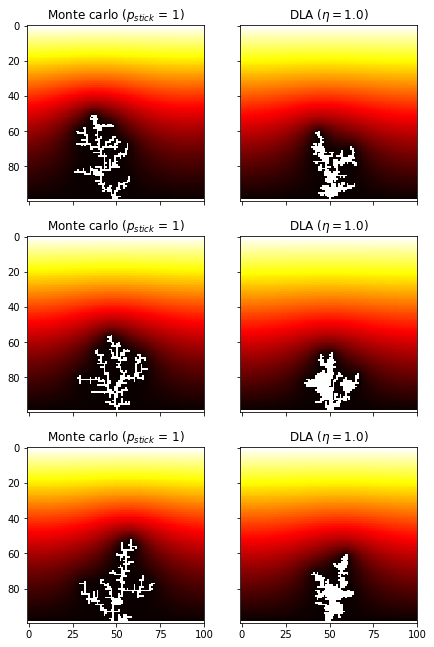

In [13]:
cluster_size = 300
eta = 1

f, axes = plt.subplots(3, 2, figsize=(7, 11), sharex='col', sharey='row')

for i in range(3):
    mcs, _ = run_mc(a_sor_2d, mask, cluster_size)
    dlas, _ = run_dla(a_sor_2d, mask, eta, cluster_size)
    
    axes[i][0].imshow(mcs[-1], cmap=mycmap, vmin=0.000000000000001, vmax=1)
    axes[i][1].imshow(dlas[-1], cmap=mycmap, vmin=0.000000000000001, vmax=1)
    
    axes[i][0].grid("off")
    axes[i][1].grid("off")
    
    axes[i][0].set_title(r"Monte carlo ($p_{stick}$ = " + str(eta) + ")")
    axes[i][1].set_title(r"DLA ($\eta = 1.0$)")

In [14]:
p_sticks = np.linspace(0.1, 1, 5)
p_mcs = []

for ps in tqdm(p_sticks):
    r, _ = run_mc(a_sor_2d, mask, 150, p_stick=ps)
    p_mcs.append(r[-1])

100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


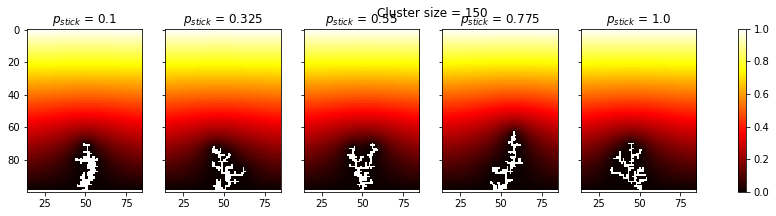

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharex='col', sharey='row')

mask = np.ones((N, N))
mask[N-1][N//2] = 0

for i, e in enumerate(p_sticks):
    N = 100
        
    ax = axes.flat[i]
    im = ax.imshow(p_mcs[i], cmap=mycmap, vmin=0.000000000000001, vmax=1)
    ax.set_title(r"$p_{stick}$ = " + str(e))
    ax.grid('off')        

fig.suptitle("Cluster size = 150")
fig.colorbar(im, ax=axes.ravel().tolist())

## 2.3

In [16]:
@njit
def gray_scott(u0, v0, delta_t, delta_x, Du, Dv, f, k):
    if (4 * delta_t * Du) / delta_x ** 2 > 1 or (4 * delta_t * Dv) / delta_x ** 2 > 1:
        raise Exception("Unstable scheme")
    
    N = u0.shape[0]

    u1 = np.zeros((N, N))
    v1 = np.zeros((N, N))
    
    # fill in new timestep
    for i in range(N):
        for j in range(N):
            ln = j - 1
            rn = j + 1
            tn = i - 1
            bn = i + 1

            # periodic boundaries
            if j == 0:
                ln = N-1
            elif j == N-1:
                rn = 0
                
            if i == 0:
                tn = N-1
            elif i == N-1:
                bn = 0

            u1[i][j] = u0[i][j] + ((delta_t * Du) / delta_x**2) * (u0[bn][j] + u0[tn][j] + u0[i][rn] + u0[i][ln] - 4 * u0[i][j]) - u0[i][j] * (v0[i][j])**2 + f*(1 - u0[i][j])
            v1[i][j] = v0[i][j] + ((delta_t * Dv) / delta_x**2) * (v0[bn][j] + v0[tn][j] + v0[i][rn] + v0[i][ln] - 4 * v0[i][j]) + u0[i][j] * (v0[i][j])**2 - (f + k)*v0[i][j]
    
    return u1, v1

In [17]:
def run_gray_scott(u0, v0, Du, Dv, f, k, iterations=1000):
    delta_t, delta_x = 1, 1

    us = [u0]
    vs = [v0]

    for i in tqdm(range(iterations)):
        u_n, v_n = gray_scott(us[-1], vs[-1], delta_t, delta_x, Du, Dv, f, k)
        us.append(u_n)
        vs.append(v_n)
        
    return us, vs   

*Experiments*

In [18]:
N = 200

u0 = np.full((N, N), 0.5)
v0 = np.zeros((N, N))
v0[80:120, 80:120] = 0.25

In [19]:
us1, vs1 = run_gray_scott(u0, v0, 0.16, 0.08, 0.035, 0.060, 5000)

100%|██████████| 5000/5000 [00:02<00:00, 2147.60it/s]


In [20]:
us2, vs2 = run_gray_scott(u0, v0, 0.15, 0.08, 0.025, 0.050, 5000)

100%|██████████| 5000/5000 [00:02<00:00, 1894.48it/s]


In [21]:
us3, vs3 = run_gray_scott(u0, v0, 0.15, 0.04, 0.067, 0.012, 5000)

100%|██████████| 5000/5000 [00:02<00:00, 1733.91it/s]


In [22]:
uss = [us1[-1], us2[-1], us3[-1]]
vss = [vs1[-1], vs2[-1], vs3[-1]]

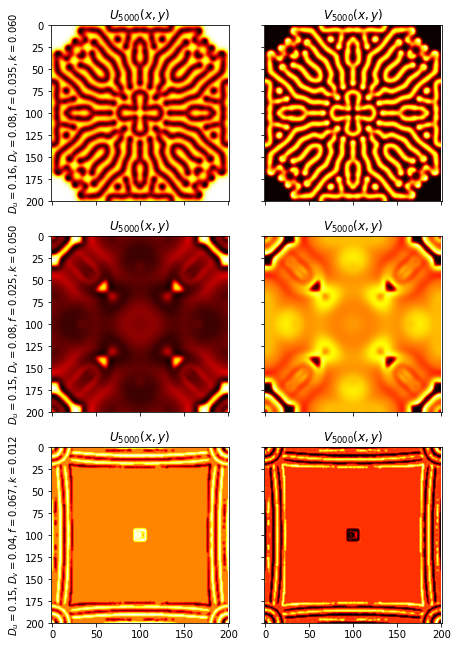

In [59]:
f, axes = plt.subplots(3, 2, figsize=(7, 11), sharex='col', sharey='row')

labels = [r"$D_u = 0.16, D_v = 0.08, f = 0.035, k = 0.060$", 
          r"$D_u = 0.15, D_v = 0.08, f = 0.025, k = 0.050$",
          r"$D_u = 0.15, D_v = 0.04, f = 0.067, k = 0.012$"]

for i in range(3):
    
    axes[i][0].set_ylabel(labels[i])

    axes[i][0].imshow(uss[i], interpolation="bicubic", cmap="hot")
    im = axes[i][1].imshow(vss[i], interpolation="bicubic", cmap="hot")

    axes[i][0].grid("off")
    axes[i][1].grid("off")

    axes[i][0].set_title(r"$U_{5000}(x, y)$")
    axes[i][1].set_title(r"$V_{5000}(x, y)$")

plt.savefig("gray-scott.pdf")

## *noise added*

In [51]:
v0 = np.zeros((N, N))
v0[20:30, 20:30] = 0.25
v0[40:50, 40:50] = 0.25
v0[100:120, 40:50] = 0.25
v0[40:90, 160:190] = 0.25
v0[160:190, 170:180] = 0.25
v0[100:125, 100:130] = 0.25

In [52]:
us_n, vs_n = run_gray_scott(u0, v0, 0.16, 0.08, 0.035, 0.060, 5000)

100%|██████████| 5000/5000 [00:01<00:00, 2502.96it/s]


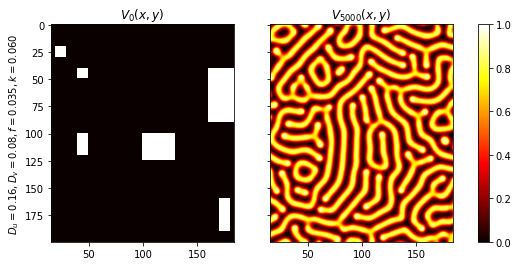

In [69]:
f, axes = plt.subplots(1, 2, figsize=(9, 4), sharex='col', sharey='row')

axes[0].set_ylabel(labels[0])
axes[0].imshow(v0, cmap="hot")
axes[0].grid("off")
axes[0].set_title(r"$V_0(x, y)$")
axes[1].imshow(vs_n[-1], interpolation="bicubic", cmap="hot")
axes[1].grid("off")
axes[1].set_title(r"$V_{5000}(x, y)$")

f.colorbar(im, ax=axes.ravel().tolist())

plt.savefig("gray-scott_noise.pdf")